# Particle Flow Notebook
### Goal:
The goal of this notebook is to simply set up the pflow code such that we can copy out data into the same format and run a simple model
### Implementation: 
For now just pull charged pion data, we have yet to add the neutral pion and shuffle them
#### To Do:
- Add neutral pion data in the same manner as charged pion and shuffle them

- No idea as of yet how to incorporate the tracking information. Speculation is that this will be a separate network, and we will concatenate the results.
  - Update on this: For now, try adding the track as just an extra point in the point cloud

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import uproot as ur
import awkward as ak
import time as t
import copy
print("Awkward Array Version: "+str(ak.__version__))
print("Uproot Version: "+str(ur.__version__))

import energyflow as ef
from energyflow.archs import EFN
from energyflow.archs import PFN
# from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

Awkward Array Version: 1.2.2
Uproot Version: 4.0.7


In [2]:
import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies')
from util import graph_util as gu

In [3]:
def find_sampling_events(_ak_cluster_cell_ID, _cellGeoID, _cellGeoSampling, _filter):
    ''' Inputs:
    _ak_cluster_cell_ID: awkward array with nested arrays of all the cell geometry IDs
    _cellGeoID: list of the cell IDs to find the index from, expects numpy format
    _cellGeoSampling: same as _cellGeoID but the sampling layer
    _filter: the numbered index of calorimetry layers
    Returns:
    an array of event indices with clusters containing barrel events
    '''

    # create unique list of sampling layers for every event
    _event_layers = []
    # list of event indices with one or more clusters in EMB1-3 or TileBar0-2
    _barrel_events = []
    
    for _evt_idx in range(len(_ak_cluster_cell_ID)):
        _cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][_evt_idx]

        # create unique list of sampling layers for every cluster
        _event_layers = []

        for j in range(len(_cluster_cell_ID)):
            ''' loop through each cluster of the event '''

            for l in range(len(_cluster_cell_ID[j])):
                ''' loop through the cluster elements searching for new layer numbers'''
                # grab the first cell_geo_ID, l-th element of the j-th cluster
                _cellGeoTag = _cluster_cell_ID[j][l]

                # find the index of the cell_geo_ID, use [0][0] becuase of np.where return
                _cellGeo_idx = np.argwhere(np.asarray(_cellGeoID == _cellGeoTag))

                # find the sampling layer based on the index
                _this_layer = _cellGeoSampling[_cellGeo_idx]

                if not np.isin(_this_layer, _event_layers):
                    _event_layers.append(_this_layer)      

        # add event to list if one is in the barrel layer
        if np.any(np.isin(_event_layers, _filter)):
            _barrel_events.append(_evt_idx)

    return np.array(_barrel_events)


def center_cluster():
    ''' Expects a single cluster with a single cluster center '''
    return None

def center_clusters():
    ''' Expects multiple clusters and creates an imshow using the average of the cluster centers'''
    return None

def cluster_to_imshow():
    ''' Takes a cluster and converts to a python imshow '''
    return None

#### Events

In [4]:
cPionEvents = '/fast_scratch/atlas_images/v01-45/pipm/'
nPionEvents = '/fast_scratch/atlas_images/v01-45/pi0/'

In [5]:
cPion_502 = ur.open(cPionEvents+'user.angerami.24559744.OutputStream._000502.root')
nPion_502 = ur.open(nPionEvents+'user.angerami.24559740.OutputStream._000502.root')

In [6]:
cPionEvents = cPion_502["EventTree"]
nPionEvents = nPion_502["EventTree"]

#### Cell Geometry

In [7]:
cellGeoTree = cPion_502["CellGeo"]

### Load & Show Trees

In [8]:
# Show keys
cPionEvents.show(name_width=42,
                interpretation_width=60)

## Event information
## Charged Pions
ak_cluster_nCells = cPionEvents.arrays(filter_name="cluster_nCells")
ak_cluster_cell_ID = cPionEvents.arrays(filter_name="cluster_cell_ID")
ak_cluster_cell_E = cPionEvents.arrays(filter_name="cluster_cell_E")
nCluster = cPionEvents.arrays(library='np')["nCluster"]
eventNumber = cPionEvents.arrays(library='np')["eventNumber"]
nTrack = cPionEvents.arrays(library='np')["nTrack"]
cPionPart = cPionEvents.arrays(library='np')["nTruthPart"]
cPionId = cPionEvents.arrays(library='np')["truthPartPdgId"]
ak_cluster_Eta = cPionEvents.arrays(filter_name="cluster_Eta")
ak_cluster_Phi = cPionEvents.arrays(filter_name="cluster_Phi")

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

#### Events - Print particle ID for reference

In [12]:
## Neutral Pions
nPionPart = nPionEvents.arrays(library='np')["nTruthPart"]
nPionId = nPionEvents.arrays(library='np')["truthPartPdgId"]

print("If single particle gun, then this should all be ones")
print("Charged Pions: ")
print(cPionPart[0:50])
print("Neutral Pions: ")
print(nPionPart[0:50]);print('.. pew pew ..'); print()

print("Check for particle data group identification of pi plus or pi minus")
print(cPionId[0:5]);print()
print("Check for particle data group identification of pi0")
print(nPionId[0:5])

If single particle gun, then this should all be ones
Charged Pions: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Neutral Pions: 
[3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]
.. pew pew ..

Check for particle data group identification of pi plus or pi minus
[array([-211], dtype=int32) array([211], dtype=int32)
 array([211], dtype=int32) array([211], dtype=int32)
 array([-211], dtype=int32)]

Check for particle data group identification of pi0
[array([111,  22,  22], dtype=int32) array([111,  22,  22], dtype=int32)
 array([111,  22,  22], dtype=int32) array([111,  22,  22], dtype=int32)
 array([111,  22,  22], dtype=int32)]


Notes: We need to be careful here about matching clusters with particles as the pions are decaying to two electrons

$\pi^0 = 111$

$\pi^{\pm} = \pm 211$

$e^{\pm} = \pm 22$

#### Cell Geometry

In [13]:
cellGeoTree.show(name_width=42,
                interpretation_width=50)

name                                       | typename                 | interpretation                                    
-------------------------------------------+--------------------------+---------------------------------------------------
cell_geo_ID                                | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling                          | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta                               | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi                               | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp                             | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta                              | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi                              | std::vector<float>       

In [14]:
# Geometry information
cell_geo_ID = cellGeoTree.arrays(filter_name='cell_geo_ID')[0]["cell_geo_ID"].to_numpy()
cell_geo_eta = cellGeoTree.arrays(filter_name='cell_geo_eta')[0]["cell_geo_eta"].to_numpy()
cell_geo_phi = cellGeoTree.arrays(filter_name='cell_geo_phi')[0]["cell_geo_phi"].to_numpy()
cell_geo_rPerp = cellGeoTree.arrays(filter_name='cell_geo_rPerp')[0]["cell_geo_rPerp"].to_numpy()
cell_geo_deta = cellGeoTree.arrays(filter_name='cell_geo_deta')[0]["cell_geo_deta"].to_numpy()
cell_geo_dphi = cellGeoTree.arrays(filter_name='cell_geo_dphi')[0]["cell_geo_dphi"].to_numpy()
cell_geo_sampling = cellGeoTree.arrays(filter_name='cell_geo_sampling')[0]["cell_geo_sampling"].to_numpy()

### Find Barrel Events

In [15]:
## Find these events for neutral pions
barrel_filter = np.array([1,2,3,12,13,14])

barrel_events = find_sampling_events(_ak_cluster_cell_ID = ak_cluster_cell_ID,
                                     _cellGeoID = cell_geo_ID, _cellGeoSampling = cell_geo_sampling,
                                     _filter = barrel_filter)
print(barrel_events[0:10])

[ 0  2  3  6  7 11 14 20 22 26]


### Set Up Clusters in Particle Flow format

#### Find maximum cluster size

In [16]:
max_cluster_num = 0

total_events = len(barrel_events)
my_event = 0
print_progress = False
ts = t.time()

# search through all the barrel events
for _evt in barrel_events:
    _clusters = ak_cluster_cell_ID["cluster_cell_ID"][_evt]
    
    my_event += 1
    _completion = my_event/total_events
    if print_progress == False and _completion >= .1:
        print_progress = True
        t_10 = t.time()
        print("10% complete in "+str(t_10 - ts)+" (s)"); print()
    
    for _clust_idx in range(nCluster[_evt]):
        _num_in_clust = len(_clusters[_clust_idx])
        if _num_in_clust > max_cluster_num:
            max_cluster_num = _num_in_clust

print('Maximum number of cells in a cluster: '+str(max_cluster_num))

10% complete in 0.12103104591369629 (s)

Maximum number of cells in a cluster: 726


### Find number of central clusters

In [23]:
num_central_clusters = 0

for _evt in barrel_events:
    
    for _clust_idx in range(nCluster[_evt]):
        _clust_Eta = ak_cluster_Eta["cluster_Eta"][_evt][_clust_idx]
        
        if np.abs(_clust_Eta) < .7:
            num_central_clusters += 1
        
print(num_central_clusters)

8909


### Create dataset

In [24]:
## Just as in the Pflow example we have a three dimensional numpy arrays with
## empty values set as a flag
X = np.zeros( (num_central_clusters, max_cluster_num, 4) )

In [25]:
def find_central_clusters(_numClusters, _ak_cluster_Eta, _events):
    ''' Goal: return an array of indices for awkward array where cells have cluster centers 
    with an eta < .7
    Inputs:
    _numClusters: a numpy array with the number of clusters in event order
    _ak_cluster_Eta: an awkward array holding the cluster eta information
    _events: a refined list of events to search though (can be all events)
    Returns:
    _central_clusters: a list of tuples containing the awkward array coordinates of central
        clusters
    '''
    
    # Empty list to concatenate array coordinates to as tuples
    _central_clusters = []
    
    for _evt_idx in _events:
        for _clust_idx in range(_numClusters[_evt]):
#             print("event "+str(_evt_idx))
#             print("number of clusters: "+str(_numClusters[_evt]))
            
            _clust_Eta = _ak_cluster_Eta["cluster_Eta"][_evt][_clust_idx]
            
            if _clust_Eta > -.7 and _clust_Eta < .7:
                _central_clusters.append((_evt_idx, _clust_idx))

    return _central_clusters

central_clusters = find_central_clusters(_numClusters=nCluster, _ak_cluster_Eta=ak_cluster_Eta,
                                         _events=barrel_events)
print(central_clusters[0:10])

[(0, 0), (2, 0), (3, 0), (6, 0), (7, 0), (11, 0), (14, 0), (20, 0), (22, 0), (26, 0)]


#### TO DO: Seems strange that seemingly none of the barrel events have multiple central clusters with abs(eta) < .7
investigate this further

In [26]:
## Still working on taking values from events and slicing them into X :-(
for i in range(len(central_clusters)):
    # unpack variables for n'th event m'th cluster
    n, m = central_clusters[i]
    _cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][n][m]
    
    for j in range(len(_cluster_cell_ID)):
        # j'th element of the m'th cluster
        _cellGeoTag = _cluster_cell_ID[j]

        # find the index of the cell_geo_ID, use [0][0] becuase of np.where return
        _cellGeo_idx = np.argwhere(np.asarray(cell_geo_ID == _cellGeoTag))
        _Eta = cell_geo_eta[_cellGeo_idx][0][0]
        _Phi = cell_geo_phi[_cellGeo_idx][0][0]
        _E = ak_cluster_cell_E["cluster_cell_E"][n][m][j]
        PID = 1 ## Fix this to proper PDGID
        
        _array_vals = np.array([_Eta, _Phi, _E, PID])
        
        X[i,j,:] = _array_vals

In [27]:
print(X[0,0:5,:])

[[-1.46141696 -2.92829227  0.19028817  1.        ]
 [-1.4614526  -2.95282793  0.00604178  1.        ]
 [-1.43639922 -2.92829227  0.02199198  1.        ]
 [-1.43643463 -2.95282793  0.02094988  1.        ]
 [-1.46131432 -2.89142489  0.13298044  1.        ]]


### Shuffle data points

# Max Example

In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
# import tensorflow as tf

#### Find Available GPUS

In [33]:
print('TensorFlow version: '+str(tf.__version__));print()
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

TensorFlow version: 2.4.0
Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU
Name: /physical_device:GPU:2   Type: GPU
Name: /physical_device:GPU:3   Type: GPU
Name: /physical_device:GPU:4   Type: GPU
Name: /physical_device:GPU:5   Type: GPU
Name: /physical_device:GPU:6   Type: GPU
Name: /physical_device:GPU:7   Type: GPU


### Grab GPU -- DONT FORGET TO CHECK WHICH ARE IN USE!!!!!!

In [34]:
gpu_list = ["/gpu:4"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:4',)
Number of devices: 1


In [35]:
# %load_ext autoreload
# %autoreload 2

data_path = '/fast_scratch/atlas_images/v01-45/'
X = np.load(data_path+'X_4.npy')

In [43]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))
print(np.shape(Y))
print(Y[89998:90002,:])

(180000, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


#### GNN Network Params
Define the mapping from observable quantities to latent space with $\Phi$

Define the mapping fomt the latent space to a general function with F

In [44]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [45]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

print('Done train/val/test split')

Done train/val/test split


In [48]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [49]:
# train model
history = pfn.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 18s 57ms/step - loss: 10.5579 - acc: 0.6715 - val_loss: 0.6474 - val_acc: 0.8149
Epoch 2/100
260/260 [==============================] - 16s 61ms/step - loss: 0.9694 - acc: 0.7467 - val_loss: 0.5169 - val_acc: 0.7027
Epoch 3/100
260/260 [==============================] - 15s 60ms/step - loss: 0.6999 - acc: 0.7509 - val_loss: 0.4505 - val_acc: 0.7548
Epoch 4/100
260/260 [==============================] - 16s 60ms/step - loss: 0.5006 - acc: 0.7661 - val_loss: 0.5210 - val_acc: 0.7537
Epoch 5/100
260/260 [==============================] - 15s 59ms/step - loss: 0.5058 - acc: 0.7605 - val_loss: 0.4061 - val_acc: 0.8030
Epoch 6/100
260/260 [==============================] - 16s 60ms/step - loss: 0.4446 - acc: 0.7708 - val_loss: 0.3955 - val_acc: 0.8060
Epoch 7/100
260/260 [==============================] - 15s 59ms/step - loss: 0.4418 - acc: 0.7844 - val_loss: 0.3899 - val_acc: 0.8223
Epoch 8/100
260/260 [==============================] -

In [50]:
preds = pfn.predict(X_test, batch_size=1000)

In [51]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

In [54]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print('PFN AUC:', auc)

PFN AUC: 0.978839045620148


## Plot Results of Training

<Figure size 432x288 with 0 Axes>

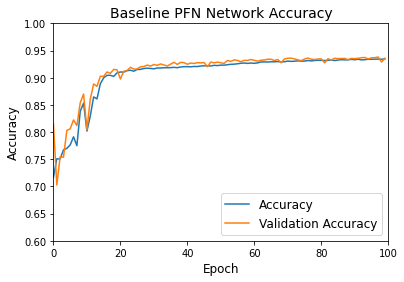

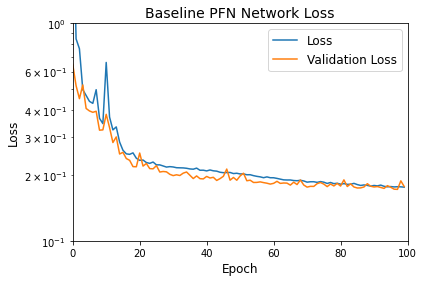

In [61]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

line1, = plt.plot(history.history['acc'], label='Accuracy')
line2, = plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Baseline PFN Network Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(handles=[line1, line2], prop={'size':12}, loc='lower right')
plt.xlim(0,100)
plt.ylim(.6,1)
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
line1, = plt.plot(history.history['loss'], label="Loss")
line2, = plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title('Baseline PFN Network Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.yscale('log')
plt.xlim(0,100)
plt.ylim(.1,1)
plt.legend(handles=[line1,line2], prop={'size':12}, loc='upper right')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

# PFN Example Code

In [15]:
## Import additionals that were not above
from __future__ import absolute_import, division, print_function

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [16]:
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

In [18]:
# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

Loaded quark and gluon jets


In [20]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('done for loop')
# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

done for loop


KeyError: 0

In [ ]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()